In [1]:
import pandas as pd
import numpy as np
import os
import pydicom
import matplotlib.pyplot as plt

from scipy.misc import imsave
from imageio import imwrite, imread
from tqdm import tqdm
from skimage import *
import itertools

import keras
from keras.preprocessing import image

%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV


# !pip install tqdm --user

/cbica/software/external/python/anaconda/2/envs/default/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%run '/gpfs/cbica/home/santhosr/Codes/utils.py'

In [3]:
numSamples0 = 200
numSamples1 = 200

X0 = []
X1 = []

baseDir0 = '/gpfs/cbica/home/santhosr/Datasets/jpeg/0'
baseDir1 = '/gpfs/cbica/home/santhosr/Datasets/jpeg/1'

# Non Cancer images
fileList = os.listdir(baseDir0)
np.random.shuffle(fileList)
fileList = fileList[:numSamples0]

for i in tqdm(range(numSamples0)):
    img = read_img(os.path.join(baseDir0,fileList[i]),(225,225))
    img = img.reshape((img.shape[0]*img.shape[1],))
    X0.append(img)
    
    
# Cancer images
fileList = os.listdir(baseDir1)
np.random.shuffle(fileList)
fileList = fileList[:numSamples1]

for i in tqdm(range(numSamples1)):
    img = read_img(os.path.join(baseDir1,fileList[i]),(225,225))
    img = img.reshape((img.shape[0]*img.shape[1],))
    X1.append(img)



100%|██████████| 200/200 [00:17<00:00, 11.59it/s]


In [4]:
X0 = np.array(X0)
X1 = np.array(X1)


In [5]:
def shuffleCombineData(x0,x1):
    
    e = [(x,0) for x in x0]
    f = [(x,1) for x in x1]
    e = e+f
    
    np.random.shuffle(e)
    
    X = np.array([x[0] for x in e])
    y = [x[1] for x in e]
    
    return X,y

In [6]:
X,y =shuffleCombineData(X0,X1)

In [7]:
X.shape

(400, 50625)

In [39]:
pcaModel = PCA(n_components=1500)
pcaModel.fit(X)

PCA(copy=True, iterated_power='auto', n_components=1500, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [40]:
np.sum(pcaModel.explained_variance_ratio_)

1.0

In [41]:
pcaX = pcaModel.transform(X)

In [42]:
pcaX.shape

(400, 400)

In [43]:
trainx,testx,trainy,testy = train_test_split(pcaX,y,test_size = 0.1)

### Random Forest

In [42]:
rfModel = RandomForestClassifier(n_estimators=1000,max_depth=6, min_samples_leaf=4)

# rfModel = RandomForestClassifier()

In [43]:
rfModel.fit(trainx,trainy)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Confusion matrix, without normalization
[[11  6]
 [13 10]]
Accuracy - Train : 1.0  Test : 0.525
F1 Score - Train : 1.0  Test : 0.512820512821
----------------------


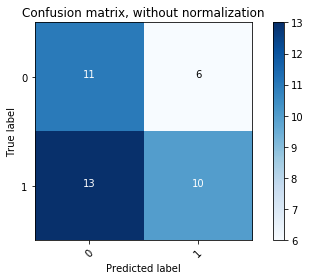

In [44]:
printResults(rfModel,trainx,trainy,testx,testy)

In [151]:
accuracy_score(testy,pred)

0.575

In [152]:
f1_score(testy,pred)


0.5142857142857143

In [153]:
cv = cross_val_score(rfModel,pcaX,y,cv=5,scoring='accuracy')

In [154]:
cv

array([0.55, 0.51, 0.6 , 0.51, 0.6 ])

In [35]:
param_grid = {"n_estimators": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

param_grid = {"n_estimators": [500,1000],
              "max_depth":[10,15]
              }

In [36]:
grid_search = GridSearchCV(rfModel, param_grid=param_grid, cv=5)

In [37]:
grid_search.fit(trainx,trainy)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [500, 1000], 'max_depth': [10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
grid_search.grid_scores_

/cbica/software/external/python/anaconda/2/envs/default/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.55278, std: 0.01380, params: {'n_estimators': 500, 'max_depth': 10},
 mean: 0.53333, std: 0.05015, params: {'n_estimators': 1000, 'max_depth': 10},
 mean: 0.52222, std: 0.03722, params: {'n_estimators': 500, 'max_depth': 15},
 mean: 0.53889, std: 0.04496, params: {'n_estimators': 1000, 'max_depth': 15}]

## XGBoost

In [13]:
 from xgboost import XGBClassifier

In [14]:
xgModel = XGBClassifier()

In [18]:
xgModel.fit(trainx,trainy)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

/cbica/software/external/python/anaconda/2/envs/default/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/cbica/software/external/python/anaconda/2/envs/default/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix, without normalization
[[12  3]
 [14 11]]
Accuracy - Train : 1.0  Test : 0.575
F1 Score - Train : 1.0  Test : 0.564102564103
----------------------


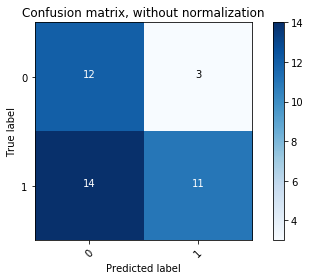

In [19]:
printResults(xgModel,trainx,trainy,testx,testy)

In [22]:
cv = cross_val_score(xgModel,pcaX,y,cv=5,scoring='accuracy')

/cbica/software/external/python/anaconda/2/envs/default/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/cbica/software/external/python/anaconda/2/envs/default/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/cbica/software/external/python/anaconda/2/envs/default/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/cbica/software/external/python/anaconda/2/env

In [23]:
cv

array([0.53, 0.56, 0.64, 0.54, 0.4 ])

In [24]:
np.mean(cv)

0.5325

## LighGBM

In [26]:
!pip install lightgbm --user

    100% |████████████████████████████████| 1.2MB 506kB/s eta 0:00:01
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [27]:
import lightgbm

In [44]:
train_data = lightgbm.Dataset(trainx,label = trainy)
test_data = lightgbm.Dataset(testx,label = testy)

In [45]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 100,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.001,
    'verbose': 0
}

In [46]:
model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=2000,
                       early_stopping_rounds=400)

[1]	valid_0's auc: 0.42803
Training until validation scores don't improve for 400 rounds.
[2]	valid_0's auc: 0.491162
[3]	valid_0's auc: 0.521465
[4]	valid_0's auc: 0.469697
[5]	valid_0's auc: 0.445707
[6]	valid_0's auc: 0.474747
[7]	valid_0's auc: 0.532828
[8]	valid_0's auc: 0.469697
[9]	valid_0's auc: 0.487374
[10]	valid_0's auc: 0.477273
[11]	valid_0's auc: 0.467172
[12]	valid_0's auc: 0.459596
[13]	valid_0's auc: 0.462121
[14]	valid_0's auc: 0.462121
[15]	valid_0's auc: 0.441919
[16]	valid_0's auc: 0.44697
[17]	valid_0's auc: 0.441919
[18]	valid_0's auc: 0.434343
[19]	valid_0's auc: 0.431818
[20]	valid_0's auc: 0.436869
[21]	valid_0's auc: 0.414141
[22]	valid_0's auc: 0.44697
[23]	valid_0's auc: 0.454545
[24]	valid_0's auc: 0.44697
[25]	valid_0's auc: 0.45202
[26]	valid_0's auc: 0.464646
[27]	valid_0's auc: 0.477273
[28]	valid_0's auc: 0.469697
[29]	valid_0's auc: 0.464646
[30]	valid_0's auc: 0.464646
[31]	valid_0's auc: 0.464646
[32]	valid_0's auc: 0.505051
[33]	valid_0's auc: 0.5

[280]	valid_0's auc: 0.54798
[281]	valid_0's auc: 0.535354
[282]	valid_0's auc: 0.532828
[283]	valid_0's auc: 0.530303
[284]	valid_0's auc: 0.532828
[285]	valid_0's auc: 0.530303
[286]	valid_0's auc: 0.535354
[287]	valid_0's auc: 0.540404
[288]	valid_0's auc: 0.537879
[289]	valid_0's auc: 0.535354
[290]	valid_0's auc: 0.542929
[291]	valid_0's auc: 0.55303
[292]	valid_0's auc: 0.55303
[293]	valid_0's auc: 0.560606
[294]	valid_0's auc: 0.555556
[295]	valid_0's auc: 0.558081
[296]	valid_0's auc: 0.555556
[297]	valid_0's auc: 0.558081
[298]	valid_0's auc: 0.560606
[299]	valid_0's auc: 0.560606
[300]	valid_0's auc: 0.565657
[301]	valid_0's auc: 0.565657
[302]	valid_0's auc: 0.570707
[303]	valid_0's auc: 0.570707
[304]	valid_0's auc: 0.560606
[305]	valid_0's auc: 0.563131
[306]	valid_0's auc: 0.563131
[307]	valid_0's auc: 0.563131
[308]	valid_0's auc: 0.563131
[309]	valid_0's auc: 0.565657
[310]	valid_0's auc: 0.568182
[311]	valid_0's auc: 0.570707
[312]	valid_0's auc: 0.560606
[313]	valid_0

[570]	valid_0's auc: 0.505051
[571]	valid_0's auc: 0.497475
[572]	valid_0's auc: 0.505051
[573]	valid_0's auc: 0.510101
[574]	valid_0's auc: 0.515152
[575]	valid_0's auc: 0.510101
[576]	valid_0's auc: 0.507576
[577]	valid_0's auc: 0.510101
[578]	valid_0's auc: 0.510101
[579]	valid_0's auc: 0.505051
[580]	valid_0's auc: 0.507576
[581]	valid_0's auc: 0.505051
[582]	valid_0's auc: 0.510101
[583]	valid_0's auc: 0.512626
[584]	valid_0's auc: 0.507576
[585]	valid_0's auc: 0.505051
[586]	valid_0's auc: 0.507576
[587]	valid_0's auc: 0.505051
[588]	valid_0's auc: 0.505051
[589]	valid_0's auc: 0.502525
[590]	valid_0's auc: 0.502525
[591]	valid_0's auc: 0.507576
[592]	valid_0's auc: 0.507576
[593]	valid_0's auc: 0.512626
[594]	valid_0's auc: 0.512626
[595]	valid_0's auc: 0.515152
[596]	valid_0's auc: 0.515152
[597]	valid_0's auc: 0.512626
[598]	valid_0's auc: 0.510101
[599]	valid_0's auc: 0.517677
[600]	valid_0's auc: 0.517677
[601]	valid_0's auc: 0.515152
[602]	valid_0's auc: 0.515152
[603]	vali